# Récupération des données fournies et Nettoyage

In [3]:
# import modules
import pandas as pd
import numpy as np
# import xlrd : to manipulate excel files

In [4]:
# dataframe
df = pd.read_excel("../corpus/all_questions.xlsx")
df.head()

,id,previous_5_turn,question,next_5_turn,categorie,annotateur,commentaire
0,1,#spk4 : monsieur,#spk4 : depuis combien de temps habitez-vous O...,#spk1 : oh ça fait neuf ans depuis dix neuf ce...,préparé,Valentin,NaN
1,2,#spk4 : monsieur | #spk4 : depuis combien de t...,#spk4 : vous vous plaisez à Orléans ?,#spk4 : pourquoi ça ? | #spk1 : bah parce que ...,préparé,Valentin,NaN
2,3,#spk4 : monsieur | #spk4 : depuis combien de t...,#spk4 : pourquoi ça ?,#spk1 : bah parce que // j'ai // j'ai toujours...,spontané,Valentin,NaN
3,4,#spk1 : oh ça fait neuf ans depuis dix neuf ce...,#spk4 : et est-ce que vous comptez rester à O...,#spk1 : oh je suis obligé par ma profession | ...,préparé,Valentin,NaN
4,5,#spk1 : bah parce que // j'ai // j'ai toujours...,#spk4 : et qu'est ce que vous faites comme tra...,#spk1 : je suis contrôleur divisionnaire aux P...,spontané,Valentin,NaN


In [5]:
df.reset_index(drop=True, inplace=True)
df = df.drop("id", axis=1)

In [6]:
# enlever les donnees inutiles
df = df.drop(df.filter(regex=("Unnamed:|commentaire")), axis=1)
df.head()

,previous_5_turn,question,next_5_turn,categorie,annotateur
0,#spk4 : monsieur,#spk4 : depuis combien de temps habitez-vous O...,#spk1 : oh ça fait neuf ans depuis dix neuf ce...,préparé,Valentin
1,#spk4 : monsieur | #spk4 : depuis combien de t...,#spk4 : vous vous plaisez à Orléans ?,#spk4 : pourquoi ça ? | #spk1 : bah parce que ...,préparé,Valentin
2,#spk4 : monsieur | #spk4 : depuis combien de t...,#spk4 : pourquoi ça ?,#spk1 : bah parce que // j'ai // j'ai toujours...,spontané,Valentin
3,#spk1 : oh ça fait neuf ans depuis dix neuf ce...,#spk4 : et est-ce que vous comptez rester à O...,#spk1 : oh je suis obligé par ma profession | ...,préparé,Valentin
4,#spk1 : bah parce que // j'ai // j'ai toujours...,#spk4 : et qu'est ce que vous faites comme tra...,#spk1 : je suis contrôleur divisionnaire aux P...,spontané,Valentin


***
# Création des sous-corpus et Affectation des attributs

In [7]:
# sous corpus
prep = df[df["categorie"] == "préparé"]
prep = prep.reset_index(drop = True)
spon = df[df["categorie"] == "spontané"]
spon = spon.reset_index(drop=True)
prep_ou_spon = df[(df["categorie"] == 'préparé') | (df["categorie"] == 'spontané')]
prep_ou_spon = prep_ou_spon.reset_index(drop=True)
#prep_ou_spon.rename(columns={"index": "ID"}, inplace=True)
len(spon)

745

In [8]:
# Extraire la colonne "question" pour les lignes filtrées
questions_spontanées = spon["question"].astype(str)
questions_préparées = prep["question"].astype(str)
toutes_questions = prep_ou_spon["question"].astype(str)

#Extraire les donnees dans les 3 premiers colonnes 
spon["text"] = spon["previous_5_turn"] + " " + spon["question"] + " " + spon["next_5_turn"]
prep["text"] = prep["previous_5_turn"] + " " + prep["question"] + " " + prep["next_5_turn"]
prep_ou_spon["text"] = prep_ou_spon["previous_5_turn"] + " " + prep_ou_spon["question"] + " " + prep_ou_spon["next_5_turn"]

text_spon = spon["text"].astype(str)
text_prep = spon["text"].astype(str)
text_tout = prep_ou_spon["text"].astype(str)

print(text_spon)

0      #spk4 : monsieur | #spk4 : depuis combien de t...
1      #spk1 : bah parce que // j'ai // j'ai toujours...
2      #spk1 : oh je suis obligé par ma profession | ...
3      #spk1 : euh c'est très vague // ben // c'est d...
4      #spk4 : hm | #spk1 : dans l'arrivée du du cour...
                             ...                        
740    #spk2 : euh donc les options obligatoires ou  ...
741    #spk2 : euh donc les options obligatoires ou  ...
742    #spk2 : l et sinon bon la bibliothèque il y a ...
743    #spk1 : l et sinon bon la bibliothèque il y a ...
744    #spk1 : et euh vous alliez à l'école à pieds o...
Name: text, Length: 745, dtype: object


***
# Annotations des textes avec `spaCy`

In [9]:
import spacy

nlp = spacy.load("fr_core_news_sm")

## Analyse globale des toutes questions elle-mêmes

In [10]:
docs = [nlp(question) for question in toutes_questions]

In [11]:
data = [(token.text, token.lemma_, token.pos_) for doc in docs for token in doc]

df = pd.DataFrame(data, columns=["Mot", "lemme", "POS"])
# Regrouper les données en fonction de la colonne "Mot" et compter les occurrences

df_grouped = df.groupby("Mot").agg({"lemme": "first", "POS": "first"}).reset_index()
df_grouped["Fréquence"] = df.groupby("Mot").size().reset_index(name="Fréquence")["Fréquence"]

df_grouped
df_ordered = df_grouped.sort_values(by="Fréquence", ascending=False)

df_ordered
df_toutesques = df_ordered.reset_index(drop=True)

df_toutesques = df_ordered[(df_ordered["POS"] != "PUNCT")]

df_toutesques

,Mot,lemme,POS,Fréquence
3,#,#,PROPN,1243
1386,spk1,spk1,ADV,877
1556,vous,vous,PRON,750
557,est,être,AUX,656
560,et,et,CCONJ,483
...,...,...,...,...
820,local,local,ADJ,1
821,logez,loger,VERB,1
822,loi,loi,NOUN,1
824,loisir,loisir,NOUN,1


**Annotation syntaxique des toutes_questions**

In [19]:
# Analyser les dépendances syntaxiques pour chaque question dans le corpus
doc_list = [nlp(question) for question in toutes_questions]

# Extraire les informations sur les dépendances syntaxiques pour chaque token dans chaque question
data = []
for doc in doc_list:
    for token in doc:
        data.append((token.text, token.dep_, token.head.text))

# Créer un dataframe à partir des informations sur les dépendances syntaxiques
df_dependencies = pd.DataFrame(data, columns=["Token", "Dépendance", "Tête"])
df_dependencies

,Token,Dépendance,Tête
0,#,expl:subj,spk4
1,spk4,ROOT,spk4
2,:,punct,spk4
3,depuis,mark,habitez
4,combien,advmod,habitez
...,...,...,...
19189,d',case,écolier
19190,écolier,nmod,é-
19191,à,case,roullens
19192,roullens,nmod,vie


**annotation morpho_syntaxique des questions spontanées**

In [12]:
docs = [nlp(question) for question in questions_spontanées]

In [15]:
data = [(token.text, token.lemma_, token.pos_) for doc in docs for token in doc]

df = pd.DataFrame(data, columns=["Mot", "lemme", "POS"])
# Regrouper les données en fonction de la colonne "Mot" et compter les occurrences

df_grouped = df.groupby("Mot").agg({"lemme": "first", "POS": "first"}).reset_index()
df_grouped["Fréquence"] = df.groupby("Mot").size().reset_index(name="Fréquence")["Fréquence"]

df_grouped
df_ordered = df_grouped.sort_values(by="Fréquence", ascending=False)

df_ordered
df_annote_spon= df_ordered.reset_index(drop=True)

df__annote_spon = df_ordered[(df_ordered["POS"] != "PUNCT")]

df_annote_spon

,Mot,lemme,POS,Fréquence
0,?,?,PUNCT,748
1,:,:,PUNCT,748
2,#,#,PROPN,745
3,spk1,spk1,ADV,560
4,vous,vous,PRON,356
...,...,...,...,...
1256,enfance,enfance,NOUN,1
1257,parliez,parler,VERB,1
1258,parlons,parlon,NOUN,1
1259,endroits,endroit,NOUN,1


**annotation morphosyntaxique des questions préparées**

In [16]:
docs = [nlp(question) for question in questions_préparées]
data = [(token.text, token.lemma_, token.pos_) for doc in docs for token in doc]

df = pd.DataFrame(data, columns=["Mot", "lemme", "POS"])
# Regrouper les données en fonction de la colonne "Mot" et compter les occurrences

df_grouped = df.groupby("Mot").agg({"lemme": "first", "POS": "first"}).reset_index()
df_grouped["Fréquence"] = df.groupby("Mot").size().reset_index(name="Fréquence")["Fréquence"]

df_grouped
df_ordered = df_grouped.sort_values(by="Fréquence", ascending=False)

df_ordered
df_annote_prep= df_ordered.reset_index(drop=True)

df__annote_prep = df_ordered[(df_ordered["POS"] != "PUNCT")]

df_annote_prep

,Mot,lemme,POS,Fréquence
0,:,:,PUNCT,498
1,#,#,PROPN,498
2,?,?,PUNCT,495
3,vous,vous,PRON,394
4,est,être,AUX,334
...,...,...,...,...
930,déplacer,déplacer,VERB,1
931,parlaient,parler,ADV,1
932,déplaceriez,déplacer,VERB,1
933,déplacez,déplacer,VERB,1


## avec les co-contextes

In [86]:
docs = [nlp(text) for text in text_tout]

data = [(token.text, token.lemma_, token.pos_) for doc in docs for token in doc]

df = pd.DataFrame(data, columns=["Mot", "lemme", "POS"])

# Regrouper les données en fonction de la colonne "Mot" et compter les occurrences

df_grouped = df.groupby("Mot").agg({"lemme": "first", "POS": "first"}).reset_index()
df_grouped["Fréquence"] = df.groupby("Mot").size().reset_index(name="Fréquence")["Fréquence"]


df_ordered = df_grouped.sort_values(by="Fréquence", ascending=False)

df_ordered

#df = df.reset_index(drop=True)

#df = df_ordered[df_ordered["POS"] == "VERB"]

#df


,Mot,lemme,POS,Fréquence
51,//,//,NOUN,15174
53,:,:,PUNCT,12421
8,#,#,PROPN,9788
3482,euh,euh,VERB,7828
2569,de,de,ADP,7738
...,...,...,...,...
4957,locataires,locataire,NOUN,1
4961,logeons,loger,VERB,1
4964,logiciels,logiciel,NOUN,1
4966,logé,loger,VERB,1


## Visualisation

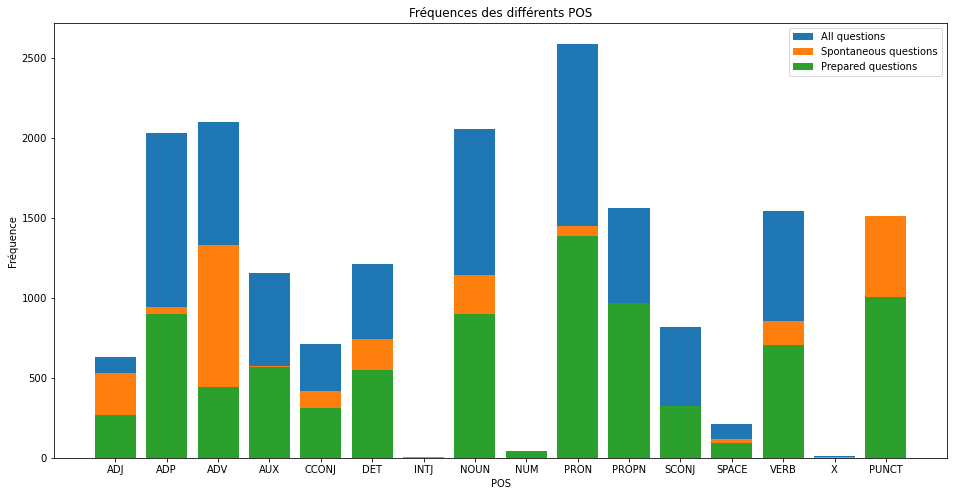

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

# Compter le nombre de chaque POS dans chaque dataframe
pos_counts_all = df_toutesques.groupby("POS").agg({"Fréquence": "sum"}).reset_index()
pos_counts_spontaneous = df_annote_spon.groupby("POS").agg({"Fréquence": "sum"}).reset_index()
pos_counts_prepared = df_annote_prep.groupby("POS").agg({"Fréquence": "sum"}).reset_index()

# Tracer un histogramme comparant les fréquences de chaque POS dans les trois dataframes
plt.bar(pos_counts_all["POS"], pos_counts_all["Fréquence"], label="Toutes questions")
plt.bar(pos_counts_spontaneous["POS"], pos_counts_spontaneous["Fréquence"], label="questions spontanées")
plt.bar(pos_counts_prepared["POS"], pos_counts_prepared["Fréquence"], label="questions préparées")
plt.xlabel("POS")
plt.ylabel("Fréquence")
plt.title("Fréquences des différents POS")
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Generer un histogramme pour les fréquences des mots dans les questions préparées
# plt.hist(df_prepared["Fréquence"], bins=30, alpha=0.5, label='Questions préparées')

# # Generer un histogramme pour les fréquences des mots dans les questions spontanées
# plt.hist(df_spontaneous["Fréquence"], bins=30, alpha=0.5, label='Questions spontanées')

# # Generer un histogramme pour les fréquences des mots dans toutes les questions
# plt.hist(df["Fréquence"], bins=30, alpha=0.5, label='Toutes les questions')

# # Ajouter une légende pour les histogrammes
# plt.legend()

# # Afficher l'histogramme
# plt.show()
